In [41]:
using DataFrames, Plots, StatsBase, Distributions, Statistics, LsqFit, Distributed,
      NaNStatistics, Base.Threads, Revise, ColorSchemes
include.(("ConstantSimulations.jl", "StaircaseSimulations.jl"))

# Psychophysics helper functions
jnd2sigma(j::Real) = (1 /quantile(Normal(), 0.75)) * j # Convert JND to σ
sigma2k(sigma::Real) = 1.7 / sigma; # Convert σ to k
sigmoid(x::Vector, coeffs::Vector) = 1 ./ (1 .+ exp.(-coeffs[1].*(x.-coeffs[2])))

# Plotting defaults
font = Plots.font("Helvetica", 9, "rgb(200,200,200)")
gr() # GR backend
gr(guidefont=font, xtickfont=font, ytickfont=font, annotationfontfamily=font, annotationfontsize=9,
 legend=false, background_color = "rgb(30,30,30)");

##### Defining the Psychometric Function
We first define an example psychophysical response function defined as a cumulative normal distribution where we define the detection threshold (μ) and just noticeable difference (which we then convert to σ). You can edit the 'detection_threshold' and 'jnd' values and re-run the cell to see how the shape of the psychometric curve changes. Note that the JND is defined as half of the distance between p(.75) and p(.25) stimulus levels. Thus, on the graph below the JND lines indicate the p(.25) and p(.75) values, but the JND is half range between them.

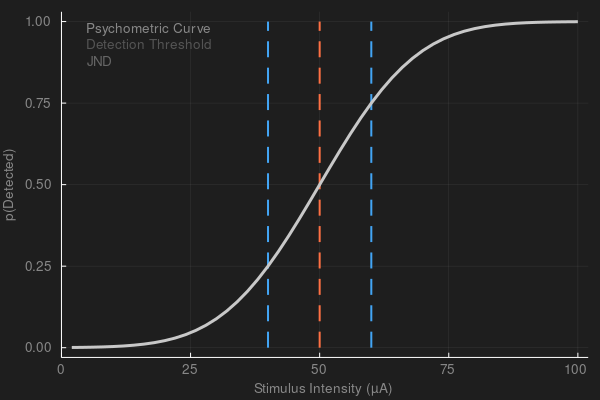

In [42]:
valid_stims = collect(2:2:100) # These are the amplitudes that can be given 
detection_threshold = 50 # microamps
jnd = 10 # microamps
sigma = jnd2sigma(jnd) # Convert for producing normal distribution

psychometric_pdf = Normal(detection_threshold, sigma) # The normal distribution
pDetected = cdf(psychometric_pdf, valid_stims) # Response probability at each stimulus

labels = ["Psychometric Curve", "Detection Threshold", "JND"]
label_colors = ["rgb(200,200,200)", "rgb(255, 112, 67)", "rgb(66, 165, 245)"]

GroundTruthPlot = plot(xlabel = "Stimulus Intensity (μA)",ylabel = "p(Detected)", xlim=(0, 102))
plot!(GroundTruthPlot, [detection_threshold, detection_threshold], [0, 1], linecolor = "rgb(255, 112, 67)",
    linestyle = :dash, linewidth = 2)
plot!(GroundTruthPlot, [detection_threshold, detection_threshold].- jnd, [0, 1],
    color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # detection_threshold
plot!(GroundTruthPlot, [detection_threshold, detection_threshold].+ jnd, [0, 1],
    color = "rgb(66, 165, 245)", linewidth = 2, linestyle = :dash) # JND
plot!(GroundTruthPlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)

yl = 1; y_dec = .05
for (l,c) in zip(labels, label_colors)
    annotate!(GroundTruthPlot, 5, yl, l, annotationhalign=:left, annotationvalign=:top, annotationcolor=c)
    yl = yl - y_dec
end
display(GroundTruthPlot)

##### Unconstrained Method of Constants:
With no prior knowledge of the psychometric curve we have to span the full range of stimuli and sample the response probability at each stimulus level. Importantly, we will always simulate this as an 2-Alternate Forced Choice (2AFC) experiment as this is the most commonly used format as it minimizes response bias without extending the duration of the experiment excessively. This means that there is a chance (1/#AFC) that the testee will select the correct interval randomly. Thus, the p(Detected) needs to be adjusted to account for this. This reduces probability bias but, as can be seen below, massively increases the variability in the measured p(Detected).

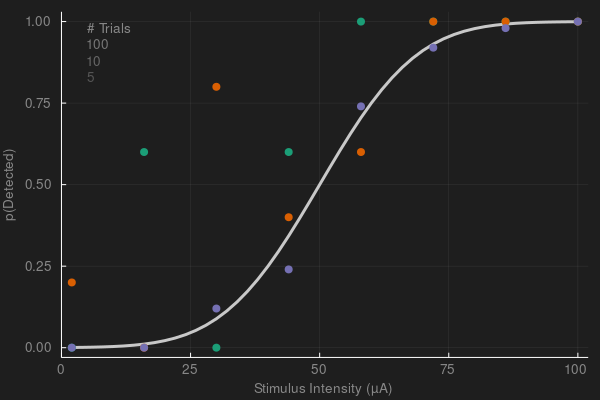

In [49]:
# Here we will choose which stimulus levels to test at
test_stims, test_stims_pDetected = GetConstantTargets(valid_stims, pDetected, Mode = "Unconstrained")
# Prepare plot
ConstantExamplePlot = plot(xlabel = "Stimulus Intensity (μA)", ylabel = "p(Detected)", xlim=(0, 102))
plot!(ConstantExamplePlot, valid_stims, pDetected, linecolor="rgb(200,200,200)", linewidth = 3)
# Show for each number of trial
yl = .85; y_dec = .05
for (i,num_trials) in enumerate([5, 10, 100])
    _, pd = ConstantSimulation(test_stims, test_stims_pDetected, num_trials, NumPerms = 1, NumAFC = 2)
    scatter!(ConstantExamplePlot, test_stims, vec(pd),  marker=:circle, markersize=5, markeralpha=1,
    markercolor=ColorSchemes.Dark2_3[i], markerstrokecolor=ColorSchemes.Dark2_3[i])
    annotate!(ConstantExamplePlot, 5, yl, num_trials, annotationhalign=:left, annotationvalign=:top,
     annotationcolor=markerstrokecolor=ColorSchemes.Dark2_3[i])
    yl = yl + y_dec
end
annotate!(ConstantExamplePlot, 5, yl, "# Trials",
 annotationhalign=:left, annotationvalign=:top, annotationcolor="rgb(200,200,200)")
display(ConstantExamplePlot)

Given that we used a 2AFC-task above, even with 100 trials we don't perfectly capture the distribution every time. You can re-run the cell to see how much variation there is, something that isn't present when NumAFC = 1, though that suffers from response bias.